# 3.word2vec

## 3.1 基于推理的方法和神经网络

In [3]:
# 基于计数方法的问题
# 基于推理方法的概要
# 神经网络中单词的处理方法
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(c, W)

In [1]:
import sys
sys.path.append("..")
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.48603232 -0.46728203 -0.54573443]]


## 3.2 简单的word2vec

In [6]:
# CBOW模型的推理
import sys
sys.path.append("..")
import numpy as np
from common.layers import MatMul

# 样本的上下文数据
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])
W_in = np.random.randn(7, 3)
W_out = np.random.rand(3, 7)

# 生成层
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s= out_layer.forward(h)

print(s)

[[ 0.03548859  0.7611332  -0.21274196 -0.33799908 -0.12674072 -0.79309418
   0.32958352]]


In [ ]:
# CBOW模型的学习
# woed2vec的权重和分布式表示

## 3.3 学习数据的准备

In [9]:
# 上下文和目标词
import sys
sys.path.append("..")
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size : -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)
create_contexts_target(corpus)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5],
        [1, 6]]),
 array([1, 2, 3, 4, 1, 5]))

In [12]:
# 转化为one-hot表示
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."

corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [16]:
target, contexts

(array([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]], dtype=int32),
 array([[[1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]]], dtype=int32))

## 3.4 CBOW模型的实现

In [28]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 生成层
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 307 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 308 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 309 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 310 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 311 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 312 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 313 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 314 |  iter 1 / 2 | time 0[s] | loss 1.54
| epoch 315 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 316 |  iter 1 / 2 | time 0[s] | loss 1.39
| epoch 317 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 318 |  iter 1 / 2 | time 0[s] | loss 1.24
| epoch 319 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 320 |  iter 1 / 2 | time 0[s] | loss 1.39
| epoch 321 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 322 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 323 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 324 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 325 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 326 |  iter 1 / 2 | time 0[s] | loss 1.53


| epoch 630 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 631 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 632 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 633 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 634 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 635 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 636 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 637 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 638 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 639 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 640 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 641 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 642 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 643 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 644 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 645 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 646 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 647 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 648 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 649 |  iter 1 / 2 | time 0[s] | loss 0.98


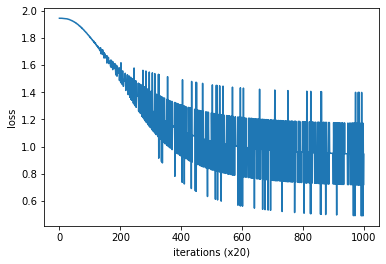

In [30]:
from common.trainer import Trainer
from common.optimizer import Adam
# from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(target, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

## 3.5 word2vec的补充说明

In [1]:
# CBOW模型和概率
# Skip-gram模型
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 生成层
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

In [ ]:
# 基于计数和基于推理